# Basic ELM stock forecasting

## Implementing a simple ELM to forecast stock market prices. Computationally quick with fairly decent RMSE (play around with number of hidden neurons and the generation of the weights and biases to optimise RMSE though).

In [1]:
# importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import pinv
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from numpy import linalg as LA

In [2]:
#pick stock and read data, datasets downloaded from yahoo finance
stock = 'NG.L' # E.g. TSLA, MSFT, AAPL, NG.L...
df = pd.read_csv(stock +'.csv', index_col = 'Date',
                       parse_dates=True)
start = 0
df = df[start:]
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-02-22,253.447800,253.447800,253.447800,253.447800,51.460205,1754802
1996-02-23,252.151398,252.151398,252.151398,252.151398,51.196999,2622706
1996-02-26,251.503204,251.503204,251.503204,251.503204,51.065376,1133831
1996-02-27,252.151398,252.151398,252.151398,252.151398,51.196999,3274077
1996-02-28,254.095993,254.095993,254.095993,254.095993,51.591827,3660425


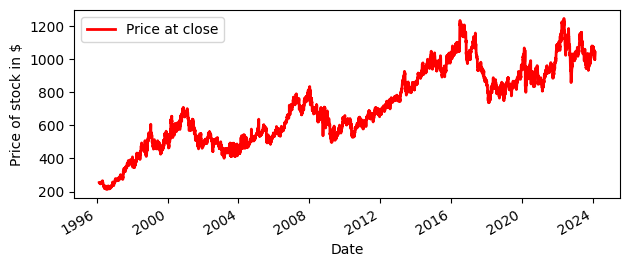

In [3]:
#Visualising data
fig = plt.figure()

#Plot price at close
ax1 = fig.add_subplot(211, xlabel ='Number of days', ylabel='Price of stock in $')
df['Close'].plot(ax=ax1, color='r', lw=2, label = 'Price at close')
ax1.legend()

plt.tight_layout()
plt.show()

In [4]:
#create 'sliding window' of data. Lag = how much of the past we want to take into account for our prediction.


lag = 5

def sliding_window(time_series, lag):
    L = len(time_series)
    X = np.zeros((L-lag, lag))
    Y = np.zeros((L-lag,1))
    posinput = lag
    posout = posinput + 1
    i = 0
    while posout<=L:
        X[i, :] = time_series[i:posinput]
        Y[i] = time_series[posout-1]
        i+=1
        posinput = lag+i
        posout = posinput + 1
    
    return X, Y




    

In [5]:
#Splitting data

train_size = int(len(df) * 0.7)

time_series_train = df.Close[:train_size].values
time_train = df.Close[:train_size].index

time_series_test = df.Close[train_size:].values
time_test = df.Close[train_size:].index



# Normalising data
mean_train = np.mean(time_series_train)
sd_train = np.std(time_series_train)
time_series_train = (time_series_train-mean_train)/sd_train
time_series_test = (time_series_test-mean_train)/sd_train


x_train, y_train = sliding_window(time_series_train,lag)
x_test, y_test = sliding_window(time_series_test,lag)

features = x_train.shape[1]

In [6]:
# Generating weights and biases (normally or uniformly distributed)
number_hidden_neurons = 10
input_weights = np.random.normal(1, 1, size=(features, number_hidden_neurons))
biases = np.random.normal(1,1, size=(number_hidden_neurons))

# activation functions
def activation_RELU(x):
    G = np.dot(x,input_weights) + biases
    return np.maximum(G, 0, G)

def activation_RBF(x):
    centres =  np.random.normal(1,1, size=(features,number_hidden_neurons))
    v = centres.T
    var = np.random.normal(0,1,size=number_hidden_neurons)
    var =np.diag(1/var**2)
    r = LA.norm(x-v[:,np.newaxis], axis = 2).T
    return np.exp(-np.dot(np.abs(r)**2,var))

    
# fitting
def fit(x):
    H = activation_RELU(x)
    return H


# ELM formula tells us that y = W H implies W = H^-1 y. If we add in a ridge regression for the weights this changes to W = A^-1 H.T y.
# A^-1 is the variance matrix defined below.

H = fit(x_train)
H_transpose = H.T
inner_product = np.dot(H_transpose, H)
Lambda = 0.001
Lambda_diag = np.diag([Lambda]*number_hidden_neurons)
variance_matrix = pinv((inner_product +Lambda_diag ))
H_y = np.dot(H_transpose,y_train)
output_weights = np.dot(variance_matrix,H_y)

    
# Prediction
def predict(x):
    out = np.dot(fit(x), output_weights)

    return out
prediction = predict(x_test)

#renormalise outputs
prediction = (prediction*sd_train) + mean_train


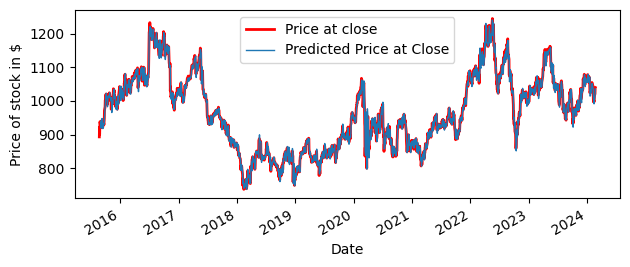

In [7]:
fig = plt.figure()


#Plot price at close
ax1 = fig.add_subplot(211, xlabel ='Number of days', ylabel='Price of stock in $')
df['Close'][train_size:].plot(ax=ax1, color='r', lw=2, label = 'Price at close')

# Plot predictions
ax1.plot(time_test[lag:], prediction[:], lw=1.0, label = 'Predicted Price at Close')
ax1.legend()

plt.tight_layout()
plt.show()

In [8]:

y_test = (y_test*sd_train) + mean_train

# RMSE
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.2f' % rmse)

#MAPE
print('Test MAPE: %.2f' % mean_absolute_percentage_error(y_test, prediction))


Test RMSE: 13.62
Test MAPE: 0.01


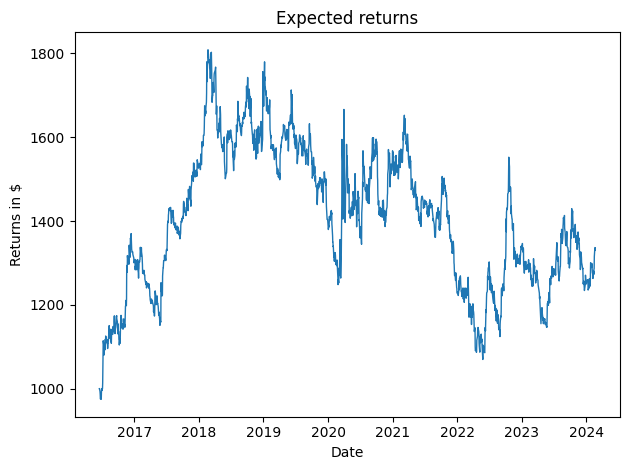

In [9]:
# Using model to buy/sell.

#initialise
capital= 1000
start_date = (df.index)[0]
end_date = (df.index)[-1]


#extracting data
prices = df.loc[start_date:end_date,'Close'].to_numpy()
logdat = df.loc[start_date:end_date,'Close'].apply(np.log).diff()

#extracting predicted data
logdat_pred = np.diff(np.log(prediction),axis=0)


#short and long windows
short = 50
long = 200

#generate the rolling short/long term average
running_short = prices[train_size +long-short:train_size +long].mean()
running_long = prices[train_size:train_size +long].mean()


#If the short term average exceeds the long signal will tell us to buy, vice-versa for selling
def event(running_short, running_long):
    return np.sign(running_short - running_long)

rets = [0]
for i in range(train_size+long, len(df)-lag-1):
    running_short+=(logdat_pred[i-train_size][0] - prices[i-train_size-short])/short
    running_long+=(logdat_pred[i-train_size][0] - prices[i-train_size-long])/long
    rets.append(rets[-1] + (event(running_short, running_long) * (logdat.iloc[i])))

out = np.exp(rets)*capital

#Plot Returns
plt.plot(time_test[lag+long:], out, lw=1.0)
plt.xlabel('Date')
plt.ylabel('Returns in $')
plt.title('Expected returns')
plt.tight_layout()
plt.show()






